In [1]:
from numpy import linalg as LA
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Groups of various sizes and ranks
np.random.seed(0)
m1 = 1000; m2 = 500; m3 = 250
n = 20
d1 = 3; d2 = 3; d3 = 6
rmax = int(np.round(1.5*(d1 + d2 + d3 + d3 + d2 + d1)))
print(rmax)

X1 = np.random.rand(m1,d1)@np.random.rand(d1,n) #large size low rank
X2 = np.random.rand(m2,d2)@np.random.rand(d2,n) #medium size low rank 
X3 = np.random.rand(m3,d3)@np.random.rand(d3,n) #small size high rank
X4 = np.random.rand(m1,d3)@np.random.rand(d3,n) #large size high rank 
X5 = np.random.rand(m2,d3)@np.random.rand(d3,n) #medium size high rank 
X6 = np.random.rand(m3,d2)@np.random.rand(d2,n) #small size low rank
 
print(X1.shape, X2.shape, X3.shape, X4.shape, X5.shape, X6.shape)
X = np.concatenate((X1,X2, X3,X4, X5, X6), axis=0)
print(X.shape)
id_A = range(0, m1)
id_B = range(m1,m1+m2)
id_C = range(m1+m2,m1+m2+m3)
id_D = range(m1+m2+m3,m1+m2+m3+m1)
id_E = range(m1+m2+m3+m1,m1+m2+m3+m1+m2)
id_F = range(m1+m2+m3+m1+m2,m1+m2+m3+m3+m2+m1)
id_all = [id_A, id_B, id_C, id_D, id_E, id_F]
print(id_A, id_B, id_C, id_D, id_E, id_F)
str_A = "Large size low rank"
str_B = "Medium size low rank"
str_C = "Small size high rank"
str_D = "large size high rank"
str_E = "medium size high rank "
str_F = "small size low rank"

X_fnmf = [X1, X2, X3, X4, X5, X6]

36
(1000, 20) (500, 20) (250, 20) (1000, 20) (500, 20) (250, 20)
(3500, 20)
range(0, 1000) range(1000, 1500) range(1500, 1750) range(1750, 2750) range(2750, 3250) range(3250, 3500)


In [23]:
eps = 10e-8
decay_factor = 0.95
def FairNMF_step(Xs, Ws, H, eta, min_errs):
    size = np.array([X.shape[0] for X in Xs])
    errs = (np.array([np.linalg.norm(X - W @ H, ord='fro') for X, W in zip(Xs,Ws)]) - min_errs) / size
    i = np.argmax(errs)
    
    Ws[i] *= ((Xs[i] @ H.T) / (Ws[i] @ H @ H.T + eps))**eta
    H *= ((Ws[i].T @ Xs[i]) / (Ws[i].T @ Ws[i] @ H + eps))**eta
    
    
    return Ws, H, errs
    
def FairNMF(Xs, num_topics, eta, max_iter = 1000):
    errs = np.zeros((max_iter,) + (len(Xs),))
    rng = np.random.default_rng()
    Ws = [rng.random((X.shape[0],) + (num_topics,)) for X in Xs]
    H = rng.random((num_topics,) + (Xs[0].shape[1],))
    
#     norms = np.array([np.linalg.norm(X, ord='fro') for X in Xs])
#     min_errs = norms.copy()
    
    min_errs = np.zeros(len(Xs))
    num_iterations=10
#    for j in range(num_iterations):
    for i in range(len(Xs)):
        model = NMF(num_topics, init="random", max_iter=5000)
        W = model.fit_transform(Xs[i])
        H = model.components_
#           min_errs[i] = np.linalg.norm(Xs[i] - W@H, ord='fro')
        min_errs[i]= np.linalg.norm(Xs[i] - W@H, ord='fro')
    min_errs= min_errs/[X.shape[0] for X in Xs]
#    avg_min_errs = min_errs / num_iterations
    
    last_three_matrices=[]
    for i in range(max_iter):
        if i>= max_iter/2:
            eta_multiplier = 1
            current_eta = eta * np.exp(-decay_factor*i/max_iter)
        else:
            eta_multiplier = 3
            current_eta = eta * eta_multiplier
            #current_eta = eta * np.exp(-decay_factor*i/max_iter)

        if len(last_three_matrices) < 3:
            Ws, H, iter_err = FairNMF_step(Xs, Ws, H, current_eta, min_errs)
            last_three_matrices.append(H)
        else:
            #average_matrix = best_weight[0]*last_three_matrices[2]+best_weight[1]*last_three_matrices[2]+best_weight[2]*last_three_matrices[2]
            average_matrix = 0.9*last_three_matrices[2]+0.05*last_three_matrices[1]+0.05*last_three_matrices[0]
            last_three_matrices.append(average_matrix)
            last_three_matrices.pop(0)
            Ws, H, iter_err = FairNMF_step(Xs, Ws, average_matrix, current_eta, min_errs)
            last_three_matrices.pop(0)
       
        errs[i,:] = iter_err
        
    return Ws, H, errs, min_errs

In [24]:
rmax = 20
I = range(1,rmax)

IT = 3
FLOSSES_V = np.zeros((IT,len(I)))
FLOSSES_A_V = np.zeros((IT,len(I)))
FLOSSES_B_V = np.zeros((IT,len(I)))
FLOSSES_C_V = np.zeros((IT,len(I)))
FLOSSES_D_V = np.zeros((IT,len(I)))
FLOSSES_E_V = np.zeros((IT,len(I)))
FLOSSES_F_V = np.zeros((IT,len(I)))

ERRS_A_V = np.zeros((IT,len(I)))
ERRS_B_V = np.zeros((IT,len(I)))
ERRS_C_V = np.zeros((IT,len(I)))
ERRS_D_V = np.zeros((IT,len(I)))
ERRS_E_V = np.zeros((IT,len(I)))
ERRS_F_V = np.zeros((IT,len(I)))

lr = 0.1
ITER_MAX = 3000

for itr in range(IT):
    print('Run #: {}'.format(itr))
    
    Floss = []
    FlossA = []
    FlossB = []
    FlossC = []
    FlossD = []
    FlossE = []
    FlossF = []
    
    for ell in I:
        print('Rank: {}'.format(ell))
        
        #Ws, H, errs = nmf.FairNMF(X_fnmf,ell,lr, max_iter=ITER_MAX)
        Ws, H, errs, min_errs = FairNMF(X_fnmf,ell,lr, max_iter=ITER_MAX)
        Xhat = np.concatenate(Ws, axis=0) @ H
        Ahat = Ws[0] @ H
        Bhat = Ws[1] @ H
        Chat = Ws[2] @ H

        Dhat = Ws[3] @ H
        Ehat = Ws[4] @ H
        Fhat = Ws[5] @ H
        
        # Reconstruction error
        
        Floss.append(LA.norm(X-Xhat, 'fro')/(X.shape[0]))

        FlossA.append((LA.norm(X[id_A,:]-Ahat, 'fro')-min_errs[0])/(len(id_A)))
        FlossB.append((LA.norm(X[id_B,:]-Bhat, 'fro')-min_errs[1])/(len(id_B)))
        FlossC.append((LA.norm(X[id_C,:]-Chat, 'fro')-min_errs[2])/(len(id_C)))
        FlossD.append((LA.norm(X[id_D,:]-Dhat, 'fro')-min_errs[3])/(len(id_D)))
        FlossE.append((LA.norm(X[id_E,:]-Ehat, 'fro')-min_errs[4])/(len(id_E)))
        FlossF.append((LA.norm(X[id_F,:]-Fhat, 'fro')-min_errs[5])/(len(id_F)))
        
#         FlossA.append((LA.norm(X[id_A,:]-Ahat, 'fro'))/(len(id_A)))
#         FlossB.append((LA.norm(X[id_B,:]-Bhat, 'fro'))/(len(id_B)))
#         FlossC.append((LA.norm(X[id_C,:]-Chat, 'fro'))/(len(id_C)))
#         FlossD.append((LA.norm(X[id_D,:]-Dhat, 'fro'))/(len(id_D)))
#         FlossE.append((LA.norm(X[id_E,:]-Ehat, 'fro'))/(len(id_E)))
#         FlossF.append((LA.norm(X[id_F,:]-Fhat, 'fro'))/(len(id_F)))
        
    FLOSSES_V[itr,:] = np.asarray(Floss)
    FLOSSES_A_V[itr,:] = np.asarray(FlossA)
    FLOSSES_B_V[itr,:] = np.asarray(FlossB)
    FLOSSES_C_V[itr,:] = np.asarray(FlossC)
    FLOSSES_D_V[itr,:] = np.asarray(FlossD)
    FLOSSES_E_V[itr,:] = np.asarray(FlossE)
    FLOSSES_F_V[itr,:] = np.asarray(FlossF)

Run #: 0
Rank: 1
Rank: 2
Rank: 3
Rank: 4
Rank: 5
Rank: 6
Rank: 7
Rank: 8
Rank: 9
Rank: 10
Rank: 11
Rank: 12
Rank: 13
Rank: 14
Rank: 15
Rank: 16
Rank: 17
Rank: 18
Rank: 19
Run #: 1
Rank: 1
Rank: 2
Rank: 3
Rank: 4
Rank: 5
Rank: 6
Rank: 7
Rank: 8
Rank: 9
Rank: 10
Rank: 11
Rank: 12
Rank: 13
Rank: 14
Rank: 15
Rank: 16
Rank: 17
Rank: 18
Rank: 19
Run #: 2
Rank: 1
Rank: 2
Rank: 3
Rank: 4
Rank: 5
Rank: 6
Rank: 7
Rank: 8
Rank: 9
Rank: 10
Rank: 11
Rank: 12
Rank: 13
Rank: 14
Rank: 15
Rank: 16
Rank: 17
Rank: 18
Rank: 19


In [25]:
FAVG_A_V = np.mean(FLOSSES_A_V, axis = 0)
FSTD_A_V = np.std(FLOSSES_A_V, axis = 0)

FAVG_B_V = np.mean(FLOSSES_B_V, axis = 0)
FSTD_B_V = np.std(FLOSSES_B_V, axis = 0)

FAVG_C_V = np.mean(FLOSSES_C_V, axis = 0)
FSTD_C_V = np.std(FLOSSES_C_V, axis = 0)

FAVG_D_V = np.mean(FLOSSES_D_V, axis = 0)
FSTD_D_V = np.std(FLOSSES_D_V, axis = 0)

FAVG_E_V = np.mean(FLOSSES_E_V, axis = 0)
FSTD_E_V = np.std(FLOSSES_E_V, axis = 0)

FAVG_F_V = np.mean(FLOSSES_F_V, axis = 0)
FSTD_F_V = np.std(FLOSSES_F_V, axis = 0)

<Figure size 432x720 with 0 Axes>

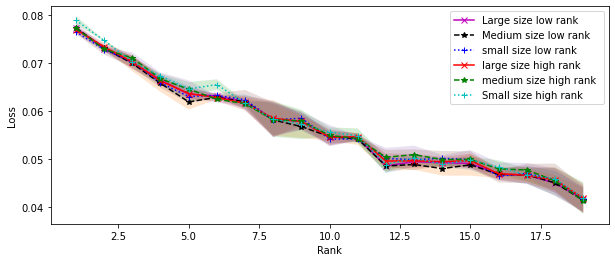

In [27]:
plt.rcParams.update({'font.size': 10})
plt.figure().set_figheight(10)
plt.figure().set_figwidth(10)
plt.plot(I, FAVG_A_V, "x-m", label=str_A)
plt.plot(I, FAVG_B_V, "*--k", label=str_B)
plt.plot(I, FAVG_F_V, "+:b", label=str_F)
plt.plot(I, FAVG_D_V, "x-r", label=str_D)
plt.plot(I, FAVG_E_V, "*--g", label=str_E)
plt.plot(I, FAVG_C_V, "+:c", label=str_C)
#plt.title("FNMF with Reweighted H on Synthetic Data")
#plt.ylim(0, 0.13)
plt.xlabel("Rank")
plt.ylabel("Loss")
plt.fill_between(I, FAVG_A_V-FSTD_A_V, FAVG_A_V+FSTD_A_V, alpha=0.2)
plt.fill_between(I, FAVG_B_V-FSTD_B_V, FAVG_B_V+FSTD_B_V, alpha=0.2)
plt.fill_between(I, FAVG_C_V-FSTD_C_V, FAVG_C_V+FSTD_C_V, alpha=0.2)
plt.fill_between(I, FAVG_D_V-FSTD_D_V, FAVG_D_V+FSTD_D_V, alpha=0.2)
plt.fill_between(I, FAVG_E_V-FSTD_E_V, FAVG_E_V+FSTD_E_V, alpha=0.2)
plt.fill_between(I, FAVG_F_V-FSTD_F_V, FAVG_F_V+FSTD_F_V, alpha=0.2)
plt.legend()
#plt.savefig('RNMF_Syn_Fair_Error.png', bbox_inches='tight')
plt.show()

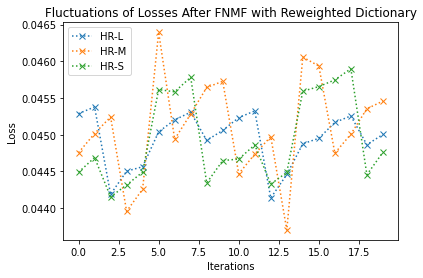

In [19]:
plt.plot(range(20),  errs[:,3][-20:], "x:", label="HR-L")
plt.plot(range(20),  errs[:,4][-20:], "x:", label="HR-M")
plt.plot(range(20),  errs[:,5][-20:], "x:", label="HR-S")
# plt.plot(range(20),  errs[:,0][-20:], "x:", label="LR-L")
# plt.plot(range(20),  errs[:,1][-20:], "x:", label="LR-M")
# plt.plot(range(20),  errs[:,2][-20:], "x:", label="LR-S")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Fluctuations of Losses After FNMF with Reweighted Dictionary")
plt.legend()